Tensorflow version: 2.8.0
keras version  2.8.0
lstm_output_units: 512 hidden_layers: 1 hidden_units: 512, dropout: 0.5 learning_rate: 0.00100 batch_size: 64 epochs: 100
Loaded data successfully!
trainX.shape, trainY.shape, testX.shape, testY.shape, validationX.shape, validationY.shape
(5305, 151, 3) (5305, 30) (1137, 151, 3) (1137, 30) (1137, 151, 3) (1137, 30)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1056768   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 30)                15390     
                      

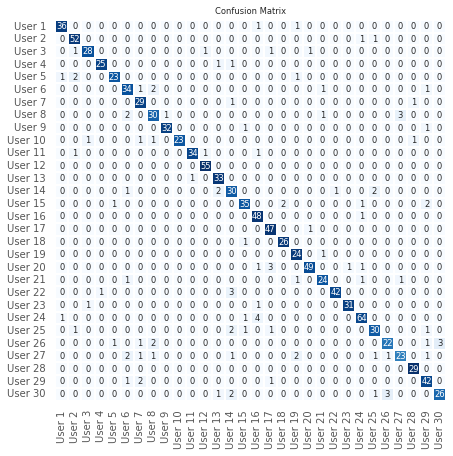

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        38
           1       0.91      0.96      0.94        54
           2       0.93      0.88      0.90        32
           3       0.96      0.93      0.94        27
           4       0.92      0.85      0.88        27
           5       0.83      0.87      0.85        39
           6       0.83      0.94      0.88        31
           7       0.83      0.81      0.82        37
           8       0.97      0.94      0.96        34
           9       1.00      0.85      0.92        27
          10       0.97      0.92      0.94        37
          11       0.96      1.00      0.98        55
          12       0.89      0.97      0.93        34
          13       0.75      0.83      0.79        36
          14       0.90      0.85      0.88        41
          15       0.86      0.98      0.91        49
          16       0.89      0.98      0.93        48
          17       0.93    

In [ ]:
import numpy
import tensorflow
import sklearn.model_selection as sk
from matplotlib import pyplot as plt
import os
import os.path
import glob
import numpy as np
# lstm model
import random
from numpy  import mean
from numpy  import std
from numpy  import dstack
from pandas import read_csv
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
#import keras
import collections
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.utils  import to_categorical
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History
from sklearn.metrics import mean_squared_error
from datetime import datetime
 
from matplotlib   import pyplot
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

#%%%%%%%%%%%%%%%%%%%Initialization information%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print('Tensorflow version:' , tensorflow.__version__)
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', tensorflow.keras.__version__)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def import_data(path):
    files = glob.glob(path +'/*.csv')
    list_of_dfs = {}
    dfs = []
    for i in range(0,len(files)):
        dfs.append(os.path.basename(files[i])[:-4])
    for df, file in zip(dfs, files):        
        list_of_dfs[df] = read_csv(file, header = None)
    print("Loaded data successfully!")
    return list_of_dfs
#NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
def show_confusion_matrix(validations, predictions): 
    matrix = metrics.confusion_matrix(validations, predictions)        
    matrix1 = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    print(matrix)
    plt.figure(figsize=(7, 7))
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sns.set(font_scale=0.7) # Adjust to fit
    ss = sns.heatmap(matrix1,
                cmap=plt.cm.Blues,
                linecolor='white',
                linewidths=1,
                annot=matrix,
                cbar=False,
                xticklabels=LABELS,
                yticklabels=LABELS,                
                fmt='')    
    figure = ss.get_figure()    
    figure.savefig(path+'unimib-user-identification.eps', dpi=400)
    plt.title('Confusion Matrix')    
    tick_marks = np.arange(n_outputs) + 0.5
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS, rotation=0)
    plt.show()
#NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
class myCallback(tensorflow.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):   
      if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
        self.model.stop_training = True
#NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
def build_model(trainX, trainY):
    history = History()
    model = Sequential()    
    model.add(LSTM(lstm_output_units, return_sequences=False, input_shape=(n_timesteps,n_features)))        
    for a in range(hidden_layers):
      model.add(Dropout(dropout))
      model.add(Dense(hidden_units, activation='swish'))   
    model.add(Dense(n_outputs, activation='softmax'))

    callbacks = myCallback()
    optimizer = optimizers.Adam(learning_rate=learning_rate)    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    #Fit network    
    history = model.fit(trainX, trainY, epochs=epochs, validation_data=(validationX, validationY), batch_size=batch_size, verbose=verbose, callbacks=[callbacks])
    return model
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def setup_data():
    # load data
    data = import_data(path)

    #Get training data:
    dataX = data[acc_data].values
    dataX = np.reshape(dataX,(dataX.shape[0],n_timesteps, n_features))   
    dataY = data[acc_labels][1].values 
    dataY = np.asarray(pd.get_dummies(dataY), dtype = np.float32)

    trainX, testX, trainY, testY = sk.train_test_split(dataX,dataY,test_size=0.3, shuffle=1, random_state = 1,stratify=dataY)
    testX, validationX, testY, validationY = sk.train_test_split(testX,testY,test_size=0.5, shuffle=1, random_state = 1,stratify=testY)

    return trainX, testX, trainY, testY, validationX, validationY        
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def start_model_training():
        
    model = build_model(trainX, trainY)    
    _, accuracy = model.evaluate(testX, testY, batch_size=batch_size, verbose=verbose)
    score = accuracy * 100.0
    print('Accuracy: %.3f' % (score))
    logfile.write('Accuracy: %.3f\r\n' % (score))
 
    y_pred_test = model.predict(testX)
    #predict test samples (select the class with the highest probability):
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testY, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    model.save(path+model_name+".h5")
    print("Saved model to disk")
    return model
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
LABELS = [ 
    "User 1",
    "User 2",
    "User 3",
    "User 4",
    "User 5",
    "User 6",
    "User 7",
    "User 8",
    "User 9",
    "User 10",
    "User 11",
    "User 12",
    "User 13",
    "User 14",
    "User 15",
    "User 16",
    "User 17",
    "User 18",
    "User 19",
    "User 20",
    "User 21",
    "User 22",
    "User 23",
    "User 24",
    "User 25",
    "User 26",
    "User 27",
    "User 28",
    "User 29",
    "User 30"
    ]
#configure all parameters, files, split, augmentation here:
path = "/content/drive/MyDrive/HAR/unimib/identification/adl-data/" #folder containing input data
filename = path+"logs/"+datetime.now().strftime("d%d-%m-%Y-t%H-%M-%S.txt")

logfile = open(filename, "w")
logfile.write("Start training the model!\r\n")

n_timesteps, n_features, n_outputs = 151, 3, 30

#hyperparameters:    
lstm_output_units = 512
hidden_layers=1
hidden_units = 512
dropout = 0.5
learning_rate = 0.001
batch_size = 64
epochs = 100
verbose=2
ACCURACY_THRESHOLD = 0.9


print("lstm_output_units: %d hidden_layers: %d hidden_units: %d, dropout: %1.1f learning_rate: %1.5f batch_size: %d epochs: %d" %(lstm_output_units, hidden_layers, hidden_units, dropout, learning_rate, batch_size, epochs))
logfile.write("hidden_layers: %d hidden_units: %d, dropout: %1.1f learning_rate: %1.5f batch_size: %d epochs: %d\r\n" %(hidden_layers, hidden_units, dropout, learning_rate, batch_size, epochs))

acc_data = 'adl_data'      
acc_labels = 'adl_labels'    

trainX, testX, trainY, testY, validationX, validationY = setup_data()

print("trainX.shape, trainY.shape, testX.shape, testY.shape, validationX.shape, validationY.shape")
print(trainX.shape, trainY.shape, testX.shape, testY.shape, validationX.shape, validationY.shape)

model_name = "adl-unimib"
model = start_model_training()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')